# 13. Splotowe sieci neuronowe

Konwolucyjne sieci neuronowe wykorzystuje się do:

* rozpoznawania obrazu
* analizy wideo
* innych zagadnień o podobnej strukturze

Innymi słowy, CNN przydają się, gdy mamy bardzo dużo danych wejściowych, w których istotne jest ich sąsiedztwo.

### Warstwy konwolucyjne

Dla uproszczenia przyjmijmy, że mamy dane w postaci jednowymiarowej – np. chcemy stwierdzić, czy na danym nagraniu obecny jest głos człowieka.

Nasze nagranie możemy reprezentować jako ciąg $n$ próbek dźwiękowych:
$$(x_0, x_1, \ldots, x_n)$$
(możemy traktować je jak jednowymiarowe „piksele”).

Najprostsza metoda – „zwykła” jednowarstwowa sieć neuronowa (każdy z każdym) nie poradzi sobie zbyt dobrze w tym przypadku:

* dużo danych wejściowych
* nie wykrywa własności „lokalnych” wejścia

Chcielibyśmy wykrywać pewne lokalne „wzory” w danych wejściowych.

W tym celu tworzymy mniejszą sieć neuronową (mniej neuronów wejściowych) i _kopiujemy_ ją tak, żeby każda jej kopia działała na pewnym fragmencie wejścia (fragmenty mogą nachodzić na siebie).

Warstwę sieci A nazywamy **warstwą konwolucyjną** (konwolucja = splot).

Warstw konwolucyjnych może być więcej niż jedna.

Tak definiujemy formalnie funckję splotu dla 2 wymiarów:

$$
\left[\begin{array}{ccc}
a & b & c\\
d & e & f\\
g & h & i\\
\end{array}\right]
*
\left[\begin{array}{ccc}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9\\
\end{array}\right] 
=\\
(1 \cdot a)+(2 \cdot b)+(3 \cdot c)+(4 \cdot d)+(5 \cdot e)\\+(6 \cdot f)+(7 \cdot g)+(8 \cdot h)+(9 \cdot i)
$$

Więcej: https://en.wikipedia.org/wiki/Kernel_(image_processing)

Jednostka warstwy konwolucyjnej może się składać z jednej lub kilku warstw neuronów.

Jeden neuron może odpowiadać np. za wykrywanie pionowych krawędzi, drugi poziomych, a jeszcze inny np. krzyżujących się linii.

### _Pooling_

Obrazy składają się na ogół z milionów pikseli. Oznacza to, że nawet po zastosowaniu kilku warstw konwolucyjnych mielibyśmy sporo parametrów do wytrenowania.

Żeby zredukować liczbę parametrów, a dzięki temu uprościć obliczenia, stosuje się warstwy ***pooling***.

*Pooling* to rodzaj próbkowania. Najpopularniejszą jego odmianą jest *max-pooling*, czyli wybieranie najwyższej wartości spośród kilku sąsiadujących pikseli (rys. 13.1).

![Rys. 13.1. Pooling](Max_pooling.png "Rys. 13.1. Pooling")

Rys. 13.1. - źródło: [Aphex34](https://commons.wikimedia.org/wiki/File:Max_pooling.png), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), Wikimedia Commons

Warstwy _pooling_ i konwolucyjne można przeplatać ze sobą (rys. 13.2).

![Rys. 13.2. CNN](Typical_cnn.png "Rys. 13.2. CNN")

Rys. 13.2. - źródło: [Aphex34](https://commons.wikimedia.org/wiki/File:Typical_cnn.png), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), Wikimedia Commons

_Pooling_ – idea: nie jest istotne, w którym *dokładnie* miejscu na obrazku dana cecha (krawędź, oko, itp.) się znajduje, wystarczy przybliżona lokalizacja.

Do sieci konwolucujnych możemy dokładać też warstwy ReLU.

https://www.youtube.com/watch?v=FmpDIaiMIeA

Zobacz też: https://colah.github.io/posts/2014-07-Conv-Nets-Modular/

### Przykład: MNIST

In [2]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random

from IPython.display import YouTubeVideo

In [3]:
import keras
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# załaduj dane i podziel je na zbiory uczący i testowy
(x_train, y_train), (x_test, y_test) = mnist.load_data()

2023-01-27 12:50:47.601029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-27 12:50:48.662241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 12:50:48.662268: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-27 12:50:51.653864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
def draw_examples(examples, captions=None):
    plt.figure(figsize=(16, 4))
    m = len(examples)
    for i, example in enumerate(examples):
        plt.subplot(100 + m * 10 + i + 1)
        plt.imshow(example, cmap=plt.get_cmap('gray'))
    plt.show()
    if captions is not None:
        print(6 * ' ' + (10 * ' ').join(str(captions[i]) for i in range(m)))

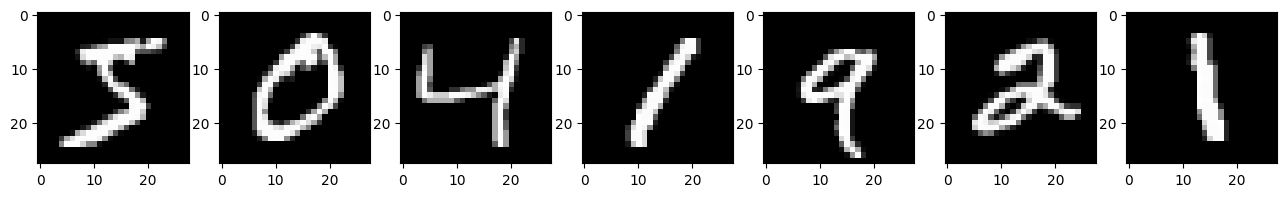

      5          0          4          1          9          2          1


In [5]:
draw_examples(x_train[:7], captions=y_train)

In [6]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

In [7]:
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape: {}'.format(x_train.shape))
print('{} train samples'.format(x_train.shape[0]))
print('{} test samples'.format(x_test.shape[0]))

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

2023-01-27 12:51:13.294000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-27 12:51:13.295301: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-27 12:51:13.295539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ELLIOT): /proc/driver/nvidia/version does not exist
2023-01-27 12:51:13.298310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [1]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [32]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 333s - loss: 0.3256 - acc: 0.9037 - val_loss: 0.0721 - val_acc: 0.9780
Epoch 2/12
60000/60000 [==============================] - 342s - loss: 0.1088 - acc: 0.9683 - val_loss: 0.0501 - val_acc: 0.9835
Epoch 3/12
60000/60000 [==============================] - 366s - loss: 0.0837 - acc: 0.9748 - val_loss: 0.0429 - val_acc: 0.9860
Epoch 4/12
60000/60000 [==============================] - 311s - loss: 0.0694 - acc: 0.9788 - val_loss: 0.0380 - val_acc: 0.9878
Epoch 5/12
60000/60000 [==============================] - 325s - loss: 0.0626 - acc: 0.9815 - val_loss: 0.0334 - val_acc: 0.9886
Epoch 6/12
60000/60000 [==============================] - 262s - loss: 0.0552 - acc: 0.9835 - val_loss: 0.0331 - val_acc: 0.9890
Epoch 7/12
60000/60000 [==============================] - 218s - loss: 0.0494 - acc: 0.9852 - val_loss: 0.0291 - val_acc: 0.9903
Epoch 8/12
60000/60000 [=======================

In [33]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.027530849870144449)
('Test accuracy:', 0.99099999999999999)
